In [1]:
import os
import random
import numpy as np
import glob
import random
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torchmetrics
import wandb
from typing import List, Dict, Tuple


### LAA -> 0

### CE -> 1


In [5]:
args = {
    "model_name": "swinv2_tiny_window16_256",
    "img_size": 256,
    "seed": 100,
    "batch_size": 32,
    "lr": 3e-4,
    "p": 0.5,
}


In [ ]:
def seed_everything(seed: int = 0):
    pl.seed_everything(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(args["seed"])


In [6]:
train_transforms = A.Compose(
    [
        A.Resize(
            args["img_size"],
            args["img_size"],
        ),
        A.HorizontalFlip(p=args["p"]),
        A.VerticalFlip(p=args["p"]),
        A.Blur(p=args["p"]),
        A.RandomBrightnessContrast(p=args["p"]),
        A.Rotate(p=args["p"]),
        A.GaussNoise(p=args["p"]),
        A.RGBShift(p=args["p"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

eval_transforms = A.Compose(
    [
        A.Resize(args["img_size"], args["img_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


In [7]:
LAA_images = [
    (filepath, 0)
    for filepath in glob.glob(
        "/kaggle/input/mayo-clinic/First Experiment/train/LAA/*.png"
    )
]
CE_images = [
    (filepath, 1)
    for filepath in glob.glob(
        "/kaggle/input/mayo-clinic/First Experiment/train/CE/*.png"
    )
]


random.shuffle(CE_images)
CE_images = CE_images[: len(LAA_images)]

data = LAA_images + CE_images
train_data, eval_data = train_test_split(data, test_size=0.3, shuffle=True)
eval_data, test_data = train_test_split(eval_data, test_size=0.5, shuffle=True)


class ClotDataset(Dataset):
    def __init__(self, data: List[Tuple], transforms=None) -> None:
        self.data = data
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path, label = self.data[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        return img, torch.tensor(label, dtype=torch.long)


train_ds = ClotDataset(train_data, train_transforms)
eval_ds = ClotDataset(eval_data, eval_transforms)
test_ds = ClotDataset(test_data, eval_transforms)

len(train_ds), len(eval_ds), len(test_ds)


(60489, 12962, 12963)

In [9]:
class LitBGModel(pl.LightningModule):
    def __init__(
        self,
        batch_size: int = 32,
        lr: float = 3e-4,
        model_name: str = "resnet50",
        args: Dict = args,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.lr = lr
        self.model = timm.create_model(model_name, pretrained=True, num_classes=2)
        self.criterion = nn.CrossEntropyLoss()

        self.test_preds, self.test_labels = [], []

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.model(img)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        preds = torch.softmax(logits, dim=-1).argmax(dim=-1)
        f1 = torchmetrics.functional.f1_score(
            preds, labels, task="multiclass", average="weighted", num_classes=2
        )
        self.log("train_f1", f1, prog_bar=True, on_epoch=True, logger=True)
        self.log("train_loss", loss, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        imgs, labels = batch
        logits = self(imgs)

        loss = self.criterion(logits, labels)
        loss = self.criterion(logits, labels)
        preds = torch.softmax(logits, dim=-1).argmax(dim=-1)
        f1 = torchmetrics.functional.f1_score(
            preds, labels, task="multiclass", average="weighted", num_classes=2
        )
        self.log("eval_f1", f1, prog_bar=True, on_epoch=True, logger=True)
        self.log("eval_loss", loss, prog_bar=True, on_epoch=True, logger=True)
        return f1

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        imgs, labels = batch
        logits = self(imgs)
        loss = self.criterion(logits, labels)
        preds = torch.softmax(logits, dim=-1).argmax(dim=-1)

        self.test_preds.extend(preds.cpu().tolist())
        self.test_labels.extend(labels.cpu().tolist())

        f1 = torchmetrics.functional.f1_score(
            preds, labels, task="multiclass", average="weighted", num_classes=2
        )
        self.log("test_f1", f1, on_epoch=True)
        self.log("test_loss", loss, on_epoch=True)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=2,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            eval_ds,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=2,
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=2,
        )

    def configure_optimizers(self) -> List[torch.optim.Optimizer]:
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return [optimizer]


In [10]:
model_name = "swinv2_tiny_window16_256"
model = LitBGModel(batch_size=32, lr=3e-4, model_name=model_name)
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="eval_f1", mode="max", patience=3),
        pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-2),
    ],
    logger=WandbLogger(project="blood-clot-merged", log_model=True, name=model_name),
    accumulate_grad_batches=4,
    deterministic=True,
    max_epochs=100,
    precision=16,
)


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


In [ ]:
trainer.fit(model)


In [11]:
trainer.test(
    model,
    ckpt_path="/kaggle/working/blood-clot-merged/17cy3xms/checkpoints/epoch=16-step=8041.ckpt",
)


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9638227224349976     │
│         test_loss         │    0.09654020518064499    │
└───────────────────────────┴───────────────────────────┘

[{'test_f1': 0.9638227224349976, 'test_loss': 0.09654020518064499}]

In [15]:
len(model.test_preds), len(model.test_labels)


(12963, 12963)

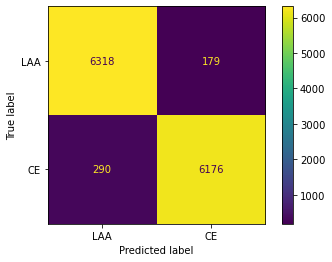

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_test, y_pred = np.array(model.test_labels), np.array(model.test_preds)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LAA", "CE"])
disp.plot()
plt.show()


In [ ]:
scripted_model = model.load_from_checkpoint(
    "/kaggle/working/blood-clot-merged/17cy3xms/checkpoints/epoch=16-step=8041.ckpt"
).to_torchscript("best_model.pt")


In [23]:
from torch.utils.mobile_optimizer import optimize_for_mobile

optimized_scripted_model = optimize_for_mobile(scripted_model)
optimized_scripted_model.save("optimized_scripted.pt")


[W TensorImpl.h:1460] Warning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (function operator())


In [24]:
optimized_scripted_model._save_for_lite_interpreter("optimized_scripted_lite.ptl")


In [26]:
ptl = torch.jit.load("optimized_scripted_lite.ptl")


In [27]:
img = torch.rand(1, 3, 256, 256, device="cpu")
with torch.autograd.profiler.profile(use_cuda=False) as prof1:
    out = scripted_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof2:
    out = optimized_scripted_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof3:
    out = ptl(img)


In [28]:
print("scripted model: {:.2f}ms".format(prof1.self_cpu_time_total / 1000))
print("optimized scripted model: {:.2f}ms".format(prof2.self_cpu_time_total / 1000))
print(
    "scripted optimized & lite model: {:.2f}ms".format(prof3.self_cpu_time_total / 1000)
)


scripted model: 816.76ms
optimized scripted model: 497.75ms
scripted optimized & lite model: 401.72ms


In [17]:
wandb.finish()


epoch,▁
test_f1,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_f1,0.96382
test_loss,0.09654
trainer/global_step,0
